In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
from torch_geometric.nn import (
    DynamicEdgeConv,
    GCNConv,
    dense_diff_pool,
    knn_graph,
    global_mean_pool
)
from torch_geometric.nn.aggr import AttentionalAggregation
from torch_geometric.utils import to_dense_batch, to_dense_adj

from tqdm import tqdm


In [12]:
def load_jets_from_npz(folder_path):

    all_files = sorted(glob.glob(f"{folder_path}/*.npz"))
    print(f"Number of files: {len(all_files)}")
    
    jet_list = []
    label_list = []
    
    for file in all_files:
        data = np.load(file)
  
        X_file = data["X"]
        y_file = data["y"]
        

        for jet, label in zip(X_file, y_file):
            jet_list.append(jet)
            label_list.append(label)
    
    return jet_list, label_list

folder_path = "data/"
X, y = load_jets_from_npz(folder_path)


Number of files: 7


In [13]:
def preprocess_data(X, y, use_log_pt=True, center_method="hardest", apply_mask=True):

    pdg_to_index = {
        22: 0,    # photon
        211: 1,   # pi+
        -211: 2,  # pi-
        130: 3,   # K0L
        321: 4,   # K+
        -321: 5,  # K-
        2212: 6,  # proton
        -2212: 7, # antiproton
        2112: 8,  # neutron
        -2112: 9, # antineutron
        11: 10,   # electron
        -11: 11,  # positron
        13: 12,   # muon-
        -13: 13,  # muon+
        15: 14,   # tau-
        -15: 15,  # tau+
        24: 16,   # W+
        -24: 17   # W-
    }
    pdg_charge_dict = {
        22: 0,
        211: 1,
        -211: -1,
        130: 0,
        321: 1,
        -321: -1,
        2212: 1,
        -2212: -1,
        2112: 0,
        -2112: 0,
        11: -1,
        -11: 1,
        13: -1,
        -13: 1,
        15: -1,
        -15: 1,
        24: 1,
        -24: -1
    }
    
    processed_list = []
    
    for jet in X:
   
        pt  = jet[:, 0].copy()   # pT
        eta = jet[:, 1].copy()   # eta
        phi = jet[:, 2].copy()   # phi
        pdg = jet[:, 3].copy()   # pdgID
        
        mask = pt > 0
        
        if use_log_pt:
            pt = np.log(pt + 1e-9)
        
        if center_method == "hardest":
            valid_indices = np.where(mask)[0]
            if valid_indices.size > 0:
                max_idx = valid_indices[np.argmax(jet[valid_indices, 0])]
                center_eta = eta[max_idx]
                center_phi = phi[max_idx]
                eta = eta - center_eta
                phi = phi - center_phi
        
        pdg_index = np.vectorize(lambda x: pdg_to_index.get(x, 0))(pdg)
        
        charge = np.vectorize(lambda x: pdg_charge_dict.get(x, 0))(pdg)
        
        processed_jet = np.stack([pt, eta, phi, pdg_index, charge], axis=-1)
        processed_list.append(processed_jet)
        
    return processed_list, y

particle_list, y_labels = preprocess_data(X, y, use_log_pt=True, center_method="hardest", apply_mask=True)


In [14]:
particle_train, particle_test, y_train, y_test = train_test_split(
    particle_list, y_labels, test_size=0.2, random_state=42
)

print("Number of jets in the training set:", len(particle_train))
print("Number of jets in the test set:", len(particle_test))

Number of jets in the training set: 560000
Number of jets in the test set: 140000


In [15]:
def create_pyg_dataset(particle_list, labels):
    data_list = []
    for jet, label in zip(particle_list, labels):
        x = torch.tensor(jet, dtype=torch.float)
        y = torch.tensor(label.astype(int), dtype=torch.long)
        data = Data(x=x, y=y)
        data_list.append(data)
    return data_list

In [16]:
class DiffPoolNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_pool_nodes=30, k=8):

        super(DiffPoolNet, self).__init__()
        self.k = k
        
        self.gnn_embed1 = GCNConv(input_dim, hidden_dim)
        self.gnn_embed2 = GCNConv(hidden_dim, hidden_dim)
        
        self.gnn_pool = GCNConv(hidden_dim, num_pool_nodes)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, data):
        x, batch = data.x, data.batch

        edge_index = knn_graph(x[:, 1:3], k=self.k, batch=batch)
        
        x_embed = F.relu(self.gnn_embed1(x, edge_index))
        x_embed = F.relu(self.gnn_embed2(x_embed, edge_index))

        S_logits = self.gnn_pool(x_embed, edge_index).float()
        S = F.softmax(S_logits, dim=-1)
        
        x_embed_dense, mask = to_dense_batch(x_embed, batch)          # [B, N, hidden_dim]
        S_dense, _ = to_dense_batch(S, batch)                           # [B, N, num_pool_nodes]
        adj_dense = to_dense_adj(edge_index, batch=batch)               # [B, N, N]
        
        x_pool, adj_pool, l1, e1 = dense_diff_pool(x_embed_dense, adj_dense, S_dense, mask)
        
        x_pool = x_pool.mean(dim=1)
        
        x_out = F.relu(self.fc1(x_pool))
        x_out = self.fc2(x_out)
        
        return F.log_softmax(x_out, dim=-1)

In [17]:
train_dataset = create_pyg_dataset(particle_train, y_train)
test_dataset  = create_pyg_dataset(particle_test, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 5        # [log(pt), eta, phi, pdg_index, charge]
hidden_dim = 64
num_classes = 2
num_pool_nodes = 20  # number of clusters for DiffPool
k = 8

model = DiffPoolNet(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, 
                    num_pool_nodes=num_pool_nodes, k=k).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} - Training", leave=False)
    for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pbar.set_postfix(loss=loss.item())
    return total_loss / len(train_dataset)

def test(loader, phase="Test"):
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"{phase} Phase", leave=False)
    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.num_graphs
            pbar.set_postfix(acc=correct/total if total > 0 else 0)
    return correct / total

num_epochs = 15
train_losses = []
train_accs = []
test_accs = []

for epoch in range(1, num_epochs+1):
    loss = train(epoch)
    train_acc = test(train_loader, phase="Train")
    test_acc = test(test_loader, phase="Test")
    
    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 01, Loss: 0.4708, Train Acc: 0.7890, Test Acc: 0.7883


Epoch: 02, Loss: 0.4552, Train Acc: 0.7939, Test Acc: 0.7940


Epoch: 03, Loss: 0.4501, Train Acc: 0.7967, Test Acc: 0.7959


Epoch: 04, Loss: 0.4473, Train Acc: 0.7965, Test Acc: 0.7954


Epoch: 05, Loss: 0.4451, Train Acc: 0.7986, Test Acc: 0.7984


Epoch: 06, Loss: 0.4436, Train Acc: 0.7988, Test Acc: 0.7982


Epoch: 07, Loss: 0.4428, Train Acc: 0.7944, Test Acc: 0.7938


Epoch: 08, Loss: 0.4417, Train Acc: 0.8007, Test Acc: 0.8004


Epoch: 09, Loss: 0.4408, Train Acc: 0.8001, Test Acc: 0.7998


Epoch: 10, Loss: 0.4401, Train Acc: 0.8014, Test Acc: 0.8008


Epoch: 11, Loss: 0.4391, Train Acc: 0.8017, Test Acc: 0.8007


Epoch: 12, Loss: 0.4383, Train Acc: 0.8019, Test Acc: 0.8015


Epoch: 13, Loss: 0.4376, Train Acc: 0.8031, Test Acc: 0.8026


Epoch: 14, Loss: 0.4374, Train Acc: 0.8034, Test Acc: 0.8020


Epoch: 15, Loss: 0.4367, Train Acc: 0.8031, Test Acc: 0.8028


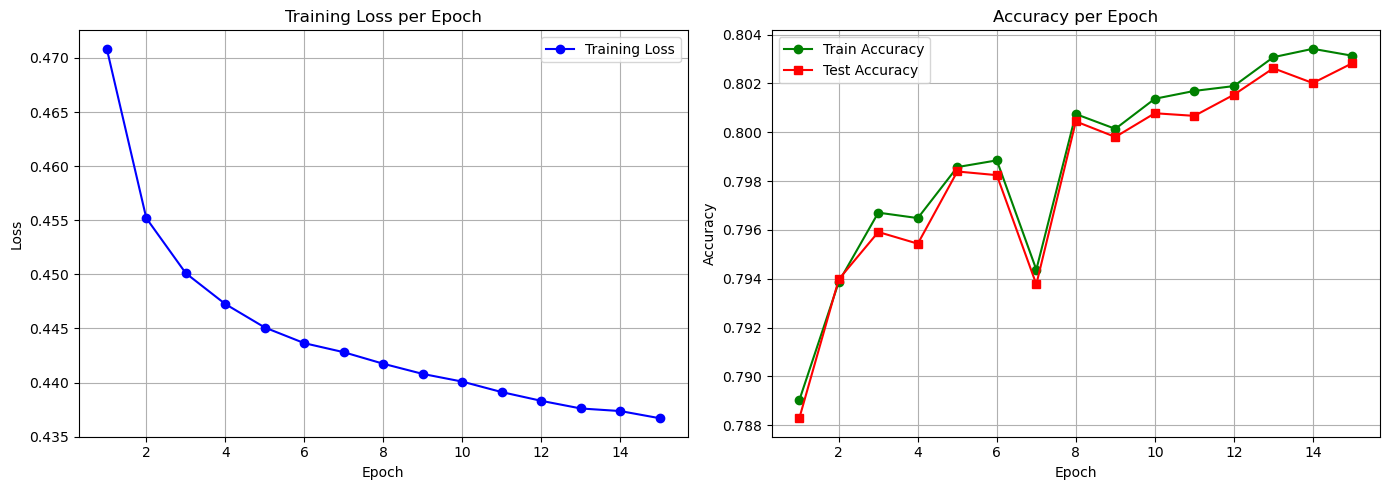

In [18]:
epochs = range(1, num_epochs + 1)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label="Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss per Epoch")
axs[0].legend()
axs[0].grid(True)
axs[1].plot(epochs, train_accs, marker='o', linestyle='-', color='green', label="Train Accuracy")
axs[1].plot(epochs, test_accs, marker='s', linestyle='-', color='red', label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy per Epoch")
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()
